In [45]:
##Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
import shutil

In [26]:
## shiting to GPU
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [27]:
# Check if GPU is available(working on CPU)
if tf.test.is_gpu_available():
    print("GPU is available")
    # To get the name of the GPU being used
    print("GPU device name: ", tf.test.gpu_device_name())
else:
    print("GPU is NOT available, running on CPU")

GPU is NOT available, running on CPU


In [28]:
dataset_dir = 'C:\\Users\\syed.ahmad\\Downloads\\CNN_Data'

# Creating directories for train, validation, and test data
train_dir = 'train'
validation_dir = 'validation'
test_dir = 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Listing all the classes (subdirectories) in the dataset_dir
classes = os.listdir(dataset_dir)

# Spliting the data and move it to the appropriate directories
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    class_images = os.listdir(class_dir)

    # Spliting the images into train, validation, and test
    train_images, val_test_images = train_test_split(class_images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

    # Moving the images to their respective directories
    for image in train_images:
        src = os.path.join(class_dir, image)
        dest = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for image in val_images:
        src = os.path.join(class_dir, image)
        dest = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_dir, image)
        dest = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

In [29]:
train_data_dir = 'train'
validation_split = 0.2  

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Creating an ImageDataGenerator for preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescaling pixels
    rotation_range=20,  # Example data augmentation parameters
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split  # Spliting the data into training and validation
)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify 'training' for training data
)

# Load and preprocess the validation data
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify 'validation' for validation data
)

Found 9059 images belonging to 37 classes.
Found 2246 images belonging to 37 classes.


In [35]:
##Neural Network
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Fully Connected Layer 1
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(37, activation='softmax'))  # 36 classes for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

In [36]:
# Load the base MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for your specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # You can adjust the number of units in this dense layer
output_layer = Dense(37, activation='softmax')(x)  # Make sure the number of units matches the number of classes

# Final model
model = Model(inputs=base_model.input, outputs=output_layer)

In [39]:
## using adam optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10

# Training the model
history = model.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=epochs
)

Epoch 1/10
284/284 [==============================] - 680s 2s/step - loss: 0.1553 - accuracy: 0.9449 - val_loss: 0.8053 - val_accuracy: 0.8063
Epoch 2/10
284/284 [==============================] - 668s 2s/step - loss: 0.1610 - accuracy: 0.9429 - val_loss: 0.7201 - val_accuracy: 0.8366
Epoch 3/10
284/284 [==============================] - 575s 2s/step - loss: 0.1369 - accuracy: 0.9500 - val_loss: 0.7283 - val_accuracy: 0.8250
Epoch 4/10
284/284 [==============================] - 435s 2s/step - loss: 0.1421 - accuracy: 0.9512 - val_loss: 0.7374 - val_accuracy: 0.8277
Epoch 5/10
284/284 [==============================] - 466s 2s/step - loss: 0.1357 - accuracy: 0.9521 - val_loss: 0.7252 - val_accuracy: 0.8215
Epoch 6/10
284/284 [==============================] - 444s 2s/step - loss: 0.1193 - accuracy: 0.9564 - val_loss: 0.7752 - val_accuracy: 0.8228
Epoch 7/10
284/284 [==============================] - 359s 1s/step - loss: 0.1531 - accuracy: 0.9451 - val_loss: 0.7714 - val_accuracy: 0.8290

In [40]:
test_data_dir = 'test'
test_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to the range [0, 1]
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set to False to maintain order for evaluation
)

Found 2444 images belonging to 37 classes.


In [41]:
## prediction
predictions = model.predict(test_generator)


77/77 [==============================] - 58s 730ms/step


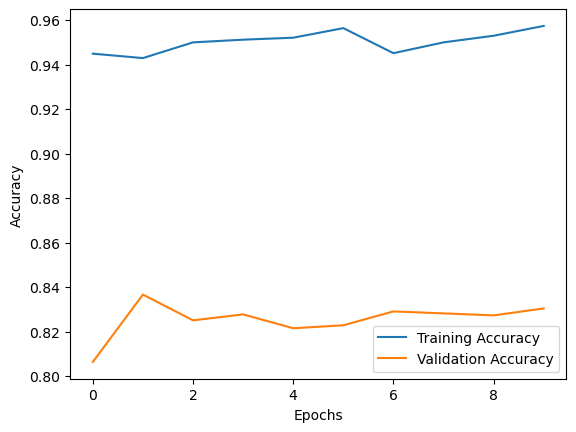

In [42]:
## plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

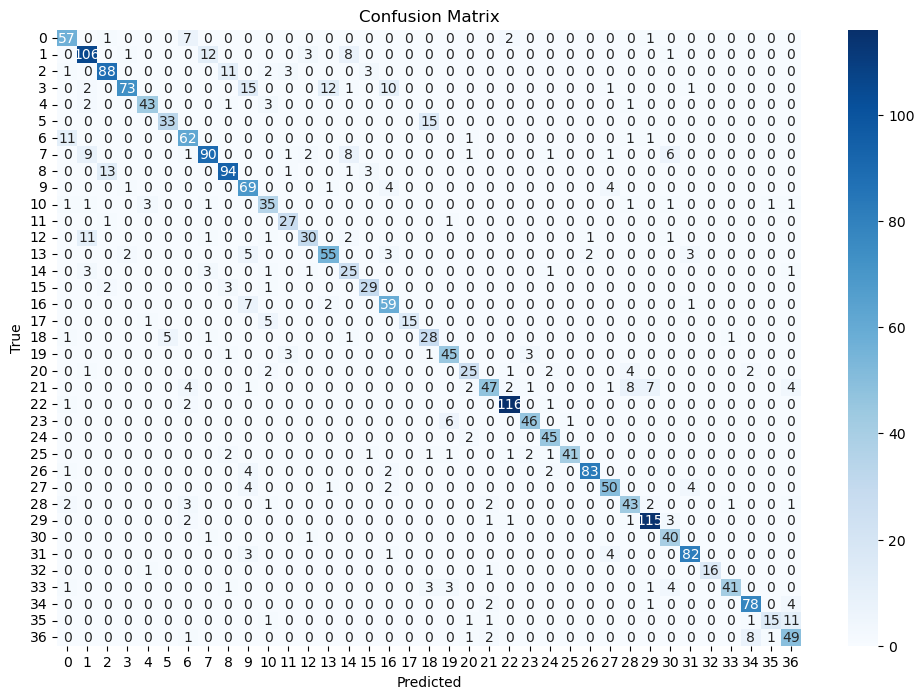

In [43]:
## Confusion Matrix
# Get the true class labels
true_labels = test_generator.classes

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
## testing the model on single picture of black dress
img_path = "C:\\Users\\syed.ahmad\\Documents\\pexels-joy-marino-3050273.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values

# Expand the dimensions of the image to match your model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

1/1 [==============================] - 1s 926ms/step


In [47]:
print(predictions)

[[9.9104065e-01 9.9503450e-10 2.6158878e-07 4.2957306e-15 2.6094266e-11
  9.1455116e-12 8.9591397e-03 2.9830358e-09 8.0062949e-11 1.0907525e-14
  2.3933470e-12 1.3280949e-12 3.4892290e-11 2.0092109e-14 6.4150974e-13
  5.1846934e-12 1.2391335e-14 2.0328055e-18 1.3766384e-14 2.6885277e-15
  4.2274033e-16 2.1039328e-14 8.3604801e-10 5.0608519e-16 4.2369125e-16
  4.8221013e-17 4.4865327e-12 1.1829883e-16 8.3147489e-09 4.0698676e-09
  1.5873846e-13 1.0842927e-15 1.1854283e-15 1.2316270e-13 1.3397873e-10
  2.2049845e-16 7.5703854e-14]]


In [57]:
## preprocessing and output
img_path = "C:\\Users\\syed.ahmad\\Documents\\pexels-joy-marino-3050273.jpg" 
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = img / 255.0  # Normalize the pixels

# Expand dimensions to match the input shape expected by the model
img = np.expand_dims(img, axis=0)

# Make a prediction
predictions = model.predict(img)

# Assuming you have class_labels defined, get the predicted class label
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

# Get the confidence score of the prediction
confidence_score = predictions[0][predicted_class_index]

# Print the predicted class label and confidence score
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score}')



1/1 [==============================] - 0s 47ms/step
Predicted class: black_dress
Confidence score: 0.9910406470298767


1/1 [==============================] - 0s 47ms/step
Predicted class: black_dress
Confidence score: 0.99
Predicted class: black_dress
Confidence score: 0.99


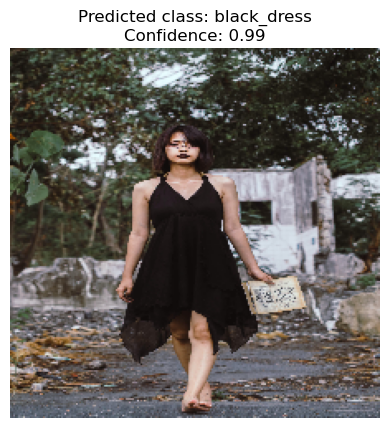

In [58]:
# Load and preprocess single image along with its picture
img_path = "C:\\Users\\syed.ahmad\\Documents\\pexels-joy-marino-3050273.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values

# Expand the dimensions of the image to match your model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Load class labels from the directory structure
class_labels = list(train_generator.class_indices.keys())

# Get the predicted class label
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]
confidence_score = predictions[0][predicted_class_index]

print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score:.2f}')  # Format the confidence score as a float with two decimal places

predicted_class_index = np.argmax(predictions, axis=1)
predicted_class_label = class_labels[predicted_class_index[0]]
confidence_score = predictions[0][predicted_class_index]

print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score[0]:.2f}')  # Format the confidence score as a float with two decimal places

# Visualize the image and the prediction
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f'Predicted class: {predicted_class_label}\nConfidence: {confidence_score[0]:.2f}')  # Format the confidence score as a float with two decimal places
plt.axis('off')
plt.show()
